In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/guns-object-detection/LICENSE
/kaggle/input/guns-object-detection/README.md
/kaggle/input/guns-object-detection/Labels/40.txt
/kaggle/input/guns-object-detection/Labels/245.txt
/kaggle/input/guns-object-detection/Labels/44.txt
/kaggle/input/guns-object-detection/Labels/141.txt
/kaggle/input/guns-object-detection/Labels/333.txt
/kaggle/input/guns-object-detection/Labels/276.txt
/kaggle/input/guns-object-detection/Labels/3.txt
/kaggle/input/guns-object-detection/Labels/244.txt
/kaggle/input/guns-object-detection/Labels/84.txt
/kaggle/input/guns-object-detection/Labels/175.txt
/kaggle/input/guns-object-detection/Labels/61.txt
/kaggle/input/guns-object-detection/Labels/69.txt
/kaggle/input/guns-object-detection/Labels/30.txt
/kaggle/input/guns-object-detection/Labels/265.txt
/kaggle/input/guns-object-detection/Labels/178.txt
/kaggle/input/guns-object-detection/Labels/201.txt
/kaggle/input/guns-object-detection/Labels/36.txt
/kaggle/input/guns-object-detection/Labels/251.txt
/

In [ ]:
import os
import cv2
import numpy as np
# from numpy.core.defchararray import join, mod #Definitive character array
#for dealing with string array
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
import requests
from io import BytesIO #Handles in memory binary streams
from PIL import Image

import random
import torch
from tqdm.notebook import tqdm

import torch.nn as nn
from torch._C import device
import torch.optim as optim

from torch.autograd import grad #Automatic gradient calculation

from torch.autograd import function as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision # Computer vision containes pre trained models

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN

from torchvision.models.detection import fasterrcnn_resnet50_fpn

from torchvision.models.detection.rpn import AnchorGenerator




In [49]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [50]:
device

device(type='cuda')

In [15]:
def imgshow(number, title=None, size=5):
    root_dir = "/kaggle/input/guns-object-detection"
    image = cv2.imread(root_dir+"/Images/"+ str(number) + ".jpeg")

    file = open(root_dir+"/Labels/"+ str(number) + ".txt", "r")
    txt_data = file.readlines()
    file.close()

    for i in range(0, int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()]
        start_point = (indices[0], indices[1]) #(x1, y1)
        end_point = (indices[2], indices[3]) #(x2, y2)

        cv2.rectangle(image, start_point, end_point, (0, 0, 255), 2) #(images, (x1, y1), (x2, y2), color(BGR), thickness)
        
    aspect_ratio = image.shape[0]/image.shape[1] # hieght/width
    
    plt.figure(figsize=(size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title+txt_data[0])
    plt.show()

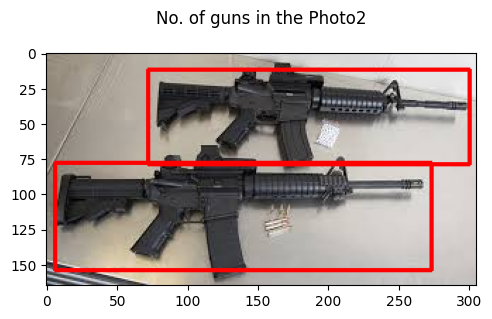

In [18]:
imgshow(119, title="No. of guns in the Photo")

In [61]:
class Gun_Data(Dataset):

    def __init__(self, root_dir):
        self.img_path = root_dir + "/Images/"
        self.labels_path = root_dir + "/Labels/"

        self.img_name = [img for img in sorted(os.listdir(self.img_path))]
        self.label_name = [img for img in sorted(os.listdir(self.labels_path))]
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_path, str(self.img_name[idx]))
        image = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)

        img_res = img_rgb / 255 # Normalizing the image.
        img_res = torch.as_tensor(img_res).permute(2, 0, 1)

        label_name = self.img_name[idx][:-4] + "txt"
        label_path = os.path.join(self.labels_path, str(label_name))

        with open(label_path, "r") as label_file:
            l_count = int(label_file.readline())
            box = []
            for i in range(l_count):
                box.append(list(map(int, label_file.readline().split())))

        target = {}
        area = []
        labels = []

        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1])
            area.append(a)

        for i in range(len(box)):
            labels.append(1)

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        img_res = img_res.to(device)
        for key in target:
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)
        return img_res, target

    def __len__(self):
        return len(self.img_name)

In [62]:
class Model:
    def __init__(self, num):
        self.num = num
        self.model = self.create_model()

    def create_model(self):
        model = fasterrcnn_resnet50_fpn(weights=True) # Pretrained rcnn model trained on resnet50 as its backbone.

        in_features = model.roi_heads.box_predictor.cls_score.in_features # Get the no. of input features in the final layer for specification.

        return model

    def compiler(self, optimizer):
        self.optimizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)

            train_loss = 0
            self.model.train()

            for img, target in train_data:
                loss_dic = self.model(img, target)
                loss = sum(loss for loss in loss_dic.values())

                self.optimizer.zero_grad()
                loss.backward()

                self.optimizer.step()
                train_loss += loss
                
            print(f"Epoch: {epoch+1} | Train Loss: {train_loss}")

In [63]:
rcnn = Model(2)
model = rcnn.model

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 30

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Gun_Data(root_dir = "/kaggle/input/guns-object-detection")

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, num_workers=0, collate_fn = collate_fn)

In [65]:
rcnn.train(train_loader, val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | Train Loss: 17.772459030151367
Epoch: 2 | Train Loss: 15.514081001281738
Epoch: 3 | Train Loss: 12.264781951904297
Epoch: 4 | Train Loss: 10.325077056884766
Epoch: 5 | Train Loss: 8.598409652709961
Epoch: 6 | Train Loss: 7.74393367767334
Epoch: 7 | Train Loss: 6.566737174987793
Epoch: 8 | Train Loss: 6.525817394256592
Epoch: 9 | Train Loss: 5.833923816680908
Epoch: 10 | Train Loss: 5.5711798667907715
Epoch: 11 | Train Loss: 5.720457077026367
Epoch: 12 | Train Loss: 5.0431599617004395
Epoch: 13 | Train Loss: 4.582627773284912
Epoch: 14 | Train Loss: 4.471115589141846
Epoch: 15 | Train Loss: 4.408459186553955
Epoch: 16 | Train Loss: 4.247593879699707
Epoch: 17 | Train Loss: 3.7586312294006348
Epoch: 18 | Train Loss: 3.7183146476745605
Epoch: 19 | Train Loss: 3.5739357471466064
Epoch: 20 | Train Loss: 3.6165716648101807
Epoch: 21 | Train Loss: 3.6950862407684326
Epoch: 22 | Train Loss: 3.4643731117248535
Epoch: 23 | Train Loss: 3.4331870079040527
Epoch: 24 | Train Loss: 3.16977

In [66]:
def test(data, number = random.randint(1, 334)):
    img, target = data[number]
    model.eval() # Eval mode on

    predictions = model([img])

    predictions = [{k:v.to(device) for k, v in t.items()} for t in predictions]

    return predictions, target, img


In [67]:
def apply_nms(orig_predictions, iou_threshold=None):
    # NMS - Non maximum seperation, # IOU - metric for object detection
    keep = torchvision.ops.nms(orig_predictions["boxes"], orig_predictions["scores"], iou_threshold)
    # coordinates of the boxes

    final_predictions = orig_predictions
    final_predictions["boxes"] = final_predictions["boxes"][keep]
    final_predictions["scores"] = final_predictions["scores"][keep]
    final_predictions["labels"] = final_predictions["labels"][keep]

    return final_predictions

In [68]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [81]:
def plot_img_bbox(img, target, size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

    for box in target["boxes"]:
        x, y, width, height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width), int(y+height)), (0, 0, 255), 2)

    aspect_ratio = img_cv.shape[0]/ img_cv.shape[1]
    plt.figure(figsize= (size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

In [88]:
predictions, target, img = test(dataset, number=1)

In [89]:
nms_prediction = apply_nms(predictions[0], iou_threshold=0.7)

In [90]:
nms_prediction

{'boxes': tensor([[115.7450, 131.1322, 162.0412, 160.0448]], device='cuda:0',
        grad_fn=<IndexBackward0>),
 'labels': tensor([1], device='cuda:0'),
 'scores': tensor([0.9998], device='cuda:0', grad_fn=<IndexBackward0>)}

In [91]:
from torchvision import transforms as torchtrans

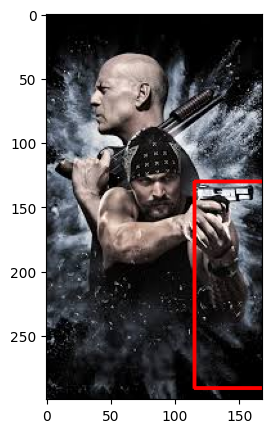

In [92]:
plot_img_bbox(torch_to_pil(img), target)

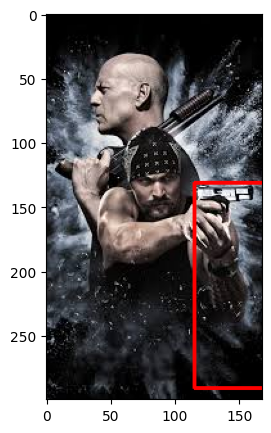

In [93]:
plot_img_bbox(torch_to_pil(img), nms_prediction)